In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
#pip install pandas-datareader

stock = 'MGLU3.SA'
source = 'yahoo'

# Set date range (Google went public August 19, 2004)
start = datetime.datetime(2004, 8, 19)
end = datetime.datetime(2019, 7, 19)

# Collect Google stock data
goog_df = data.DataReader(stock, source, start, end)

dataset = goog_df['Adj Close']
print(len(dataset))
goog_df['Adj Close'].plot(kind='line', grid=True, title='GOOG Adjusted Closes, IPO through 2016')


2037


In [2]:
import tensorflow as tf
import pandas as pd  
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow_probability as tfp


dataset = np.array(dataset.astype('float32')).reshape(-1,1)

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

#dataset=norm(dataset)

look_back=4
np.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.99)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

def create_dataset(dataset, look_back=look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX

trainY = trainY.reshape(len(trainY), 1)
testY = testY.reshape(len(testY), 1)
trainY

X0=trainX
Y0=trainY



2016 21


In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
tfd = tfp.distributions

class TemporalConvNet(tf.layers.Layer):
    def __init__(self, num_channels, kernel_size=2, dropout=0.2,
                 trainable=True, name=None, dtype=None, 
                 activity_regularizer=None, **kwargs):
        super(TemporalConvNet, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs
        )
        self.layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            out_channels = num_channels[i]
            self.layers.append(
                TemporalBlock(out_channels, kernel_size, strides=1, dilation_rate=dilation_size,
                              dropout=dropout, name="tblock_{}".format(i))
            )
    
    def call(self, inputs, training=True):
        outputs = inputs
        for layer in self.layers:
            outputs = layer(outputs, training=training)
        return outputs

learning_rate = 0.001
display_step = 10
num_input = 1
num_hidden = 35
num_classes = 1

dropout = 0
kernel_size = 8
levels = 6

class CausalConv1D(tf.layers.Conv1D):
    def __init__(self, filters,
               kernel_size,
               strides=1,
               dilation_rate=1,
               activation=None,
               use_bias=True,
               kernel_initializer=None,
               bias_initializer=tf.zeros_initializer(),
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               trainable=True,
               name=None,
               **kwargs):
        super(CausalConv1D, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='valid',
            data_format='channels_last',
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            trainable=trainable,
            name=name, **kwargs
        )
       
    def call(self, inputs):
        padding = (self.kernel_size[0] - 1) * self.dilation_rate[0]
        inputs = tf.pad(inputs, tf.constant([(0, 0,), (1, 0), (0, 0)]) * padding)
        return super(CausalConv1D, self).call(inputs)



class TemporalBlock(tf.layers.Layer):
    def __init__(self, n_outputs, kernel_size, strides, dilation_rate, dropout=0.1, 
                 trainable=True, name=None, dtype=None, 
                 activity_regularizer=None, **kwargs):
        super(TemporalBlock, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs
        )        
        self.dropout = dropout
        self.n_outputs = n_outputs
        self.conv1 = CausalConv1D(
            n_outputs, kernel_size, strides=strides, 
            dilation_rate=dilation_rate, activation=tf.nn.relu, 
            name="conv1")
        self.conv2 = CausalConv1D(
            n_outputs, kernel_size, strides=strides, 
            dilation_rate=dilation_rate, activation=tf.nn.relu, 
            name="conv2")
        self.down_sample = None

    
    def build(self, input_shape):
        channel_dim = 2
        self.dropout1 = tf.layers.Dropout(self.dropout, [tf.constant(1), tf.constant(1), tf.constant(self.n_outputs)])
        self.dropout2 = tf.layers.Dropout(self.dropout, [tf.constant(1), tf.constant(1), tf.constant(self.n_outputs)])
        if input_shape[channel_dim] != self.n_outputs:
            self.down_sample = tf.layers.Dense(self.n_outputs, activation=None)
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout2(x, training=training)
        #x = tfp.layers.DistributionLambda(make_distribution_fn=lambda t: tfd.Normal(loc=t, scale=1))(x)
        #x = tf.contrib.layers.layer_norm(x)
        #x = tf.layers.dense(inputs=x,units=3)
        if self.down_sample is not None:
          inputs = self.down_sample(inputs)
        return tf.nn.relu(x)



tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    tf.set_random_seed(2)
    
    X = tf.placeholder("float", [None, look_back,1])
    Y = tf.placeholder("float", [None, num_classes])
    is_training = tf.placeholder("bool")
    
    logits = tf.layers.dense(
        TemporalConvNet([num_hidden] * levels, kernel_size, dropout)(
            X, training=is_training),
        num_classes, activation=None, 
        kernel_initializer=tf.glorot_uniform_initializer()
    )
    print(logits)

    mm,_=tf.nn.moments(tf.reshape(tf.nn.relu(logits),[-1,look_back]),axes=[1])
    prediction=tf.nn.relu(logits)
    
    prediction2 = tf.reshape(tf.cast(mm,tf.float32),[-1,1])
    
    loss_op = tf.reduce_mean(tf.losses.mean_squared_error(
        labels=Y,predictions=prediction2))
    
    accuracy=1-tf.sqrt(loss_op)

    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss_op)


    saver = tf.train.Saver()
    print("All parameters:", np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.global_variables()]))
    print("Trainable parameters:", np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()]))

def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle).astype(np.float32), np.asarray(labels_shuffle).astype(np.float32)

log_dir = "/home/rubensvectomobile/BOVESPA/"
tb_writer = tf.summary.FileWriter(log_dir, graph)
config = tf.ConfigProto()
config.gpu_options.allow_growth = False
config.gpu_options.per_process_gpu_memory_fraction = 0.7
best_val_acc = 0.82

training_epochs = 2000
batch_size = X0.shape[0]


X0=X0.reshape(-1,look_back,1)
testX=testX.reshape(-1,look_back,1)


W0723 18:22:27.912771 139908726810368 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0723 18:22:28.028303 139908726810368 deprecation.py:506] From /home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0723 18:22:29.331206 139908726810368 deprecation.py:323] From <ipython-input-4-804ec30d0b74>:140: dense (from tensorflow.python.layers.core) is deprec

Tensor("dense/BiasAdd:0", shape=(?, 4, 1), dtype=float32)
All parameters: 328200.0
Trainable parameters: 109446


In [5]:

with tf.Session(graph=graph, config=config) as sess:
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)
    for step in range(1, training_epochs+1):
        Xt, Yt = next_batch(batch_size, X0, Y0)
        batch_x, batch_y = Xt,Yt
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, is_training: True})
        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy], feed_dict={
                X: batch_x, Y: batch_y, is_training: False})
            test_data = testX
            test_label = testY
            val_acc = sess.run(accuracy, feed_dict={X: test_data, Y: test_label, is_training: False})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.4f}".format(acc) + ", Test Accuracy= " + \
                  "{:.4f}".format(val_acc))
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                save_path = saver.save(sess, "/home/rubensvectomobile/BOVESPA/model.ckpt")
                print("Model saved in path: %s" % save_path)
    pred00 = sess.run([prediction], feed_dict={X: test_data, is_training: False})
    pred01 = sess.run([prediction2], feed_dict={X: test_data, is_training: False})


Step 1, Minibatch Loss= 0.0468, Training Accuracy= 0.7836, Test Accuracy= 0.1823
Step 10, Minibatch Loss= 0.0065, Training Accuracy= 0.9193, Test Accuracy= 0.5723
Step 20, Minibatch Loss= 0.0009, Training Accuracy= 0.9692, Test Accuracy= 0.8943
Model saved in path: /home/rubensvectomobile/BOVESPA/model.ckpt
Step 30, Minibatch Loss= 0.0004, Training Accuracy= 0.9797, Test Accuracy= 0.8681
Step 40, Minibatch Loss= 0.0002, Training Accuracy= 0.9854, Test Accuracy= 0.9062
Model saved in path: /home/rubensvectomobile/BOVESPA/model.ckpt
Step 50, Minibatch Loss= 0.0002, Training Accuracy= 0.9859, Test Accuracy= 0.8743
Step 60, Minibatch Loss= 0.0002, Training Accuracy= 0.9872, Test Accuracy= 0.8953
Step 70, Minibatch Loss= 0.0001, Training Accuracy= 0.9883, Test Accuracy= 0.9111
Model saved in path: /home/rubensvectomobile/BOVESPA/model.ckpt
Step 80, Minibatch Loss= 0.0001, Training Accuracy= 0.9886, Test Accuracy= 0.9082
Step 90, Minibatch Loss= 0.0001, Training Accuracy= 0.9890, Test Accura

Step 890, Minibatch Loss= 0.0001, Training Accuracy= 0.9915, Test Accuracy= 0.9358
Step 900, Minibatch Loss= 0.0001, Training Accuracy= 0.9922, Test Accuracy= 0.9463
Step 910, Minibatch Loss= 0.0001, Training Accuracy= 0.9881, Test Accuracy= 0.9186
Step 920, Minibatch Loss= 0.0001, Training Accuracy= 0.9920, Test Accuracy= 0.9525
Step 930, Minibatch Loss= 0.0001, Training Accuracy= 0.9896, Test Accuracy= 0.9280
Step 940, Minibatch Loss= 0.0001, Training Accuracy= 0.9912, Test Accuracy= 0.9609
Step 950, Minibatch Loss= 0.0001, Training Accuracy= 0.9902, Test Accuracy= 0.9668
Step 960, Minibatch Loss= 0.0001, Training Accuracy= 0.9921, Test Accuracy= 0.9438
Step 970, Minibatch Loss= 0.0002, Training Accuracy= 0.9844, Test Accuracy= 0.9020
Step 980, Minibatch Loss= 0.0001, Training Accuracy= 0.9906, Test Accuracy= 0.9225
Step 990, Minibatch Loss= 0.0001, Training Accuracy= 0.9913, Test Accuracy= 0.9575
Step 1000, Minibatch Loss= 0.0001, Training Accuracy= 0.9897, Test Accuracy= 0.9318
Ste

Step 1860, Minibatch Loss= 0.0001, Training Accuracy= 0.9925, Test Accuracy= 0.9567
Step 1870, Minibatch Loss= 0.0001, Training Accuracy= 0.9905, Test Accuracy= 0.9637
Step 1880, Minibatch Loss= 0.0001, Training Accuracy= 0.9911, Test Accuracy= 0.9327
Step 1890, Minibatch Loss= 0.0002, Training Accuracy= 0.9863, Test Accuracy= 0.9693
Step 1900, Minibatch Loss= 0.0001, Training Accuracy= 0.9891, Test Accuracy= 0.9547
Step 1910, Minibatch Loss= 0.0001, Training Accuracy= 0.9919, Test Accuracy= 0.9405
Step 1920, Minibatch Loss= 0.0001, Training Accuracy= 0.9927, Test Accuracy= 0.9383
Step 1930, Minibatch Loss= 0.0001, Training Accuracy= 0.9925, Test Accuracy= 0.9446
Step 1940, Minibatch Loss= 0.0001, Training Accuracy= 0.9928, Test Accuracy= 0.9498
Step 1950, Minibatch Loss= 0.0001, Training Accuracy= 0.9919, Test Accuracy= 0.9621
Step 1960, Minibatch Loss= 0.0001, Training Accuracy= 0.9908, Test Accuracy= 0.9314
Step 1970, Minibatch Loss= 0.0001, Training Accuracy= 0.9909, Test Accuracy=

In [6]:
with tf.Session(graph=graph, config=config) as session:
    ckpt = "/home/rubensvectomobile/BOVESPA/model.ckpt"
    saver.restore(session, ckpt)
    pred00 = session.run([prediction], feed_dict={X: test_data, is_training: False})
    pred01 = session.run([prediction2], feed_dict={X: test_data, is_training: False})




W0723 18:24:28.359713 139908726810368 deprecation.py:323] From /home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


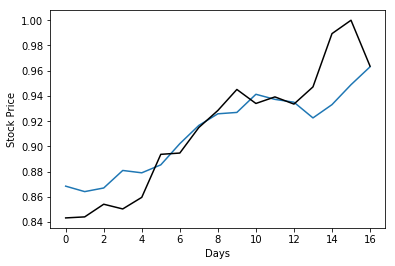

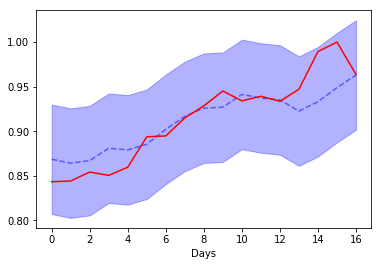

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.array(pred01).reshape(-1,1))
plt.plot(np.array(testY).reshape(-1,),c='black')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

x=list(range(0,len(pred00[0])))
y1=np.array(pred01).reshape(1,-1)[0]+2*np.std(np.array(pred01).reshape(1,-1))
y2=np.array(pred01).reshape(1,-1)[0]-2*np.std(np.array(pred01).reshape(1,-1))
fig, ax1 = plt.subplots(1, 1, sharex=True)
ax1.plot(np.array(pred01).reshape(1,-1)[0],'--',color='blue',alpha=0.5)
ax1.fill_between(x, y1, y2,color='blue',alpha=0.3)
ax1.plot(x,np.array(testY).reshape(-1,),c='red')
plt.xlabel('Days')
plt.show()

In [8]:
from sklearn.metrics import r2_score
print('R2',r2_score(testY.reshape(1,-1)[0],np.array(pred01).reshape(1,-1)[0]))

R2 0.7673748715030778


In [9]:
x_test=X0[-1].reshape(-1,4,1)
prev=[]
with tf.Session(graph=graph, config=config) as session:
    ckpt = "/home/rubensvectomobile/BOVESPA/model.ckpt"
    saver.restore(session, ckpt)
    for i in range(0,21):
        pred02 = session.run([prediction2], feed_dict={X: x_test, is_training: False})[0][0]
        prev.append(pred02)
        #print(pred02)
        x_test=np.concatenate([x_test[0][1:4],[pred02]],axis=0).reshape(-1,4,1)
        #print(x_test)
        


In [10]:
limit=8

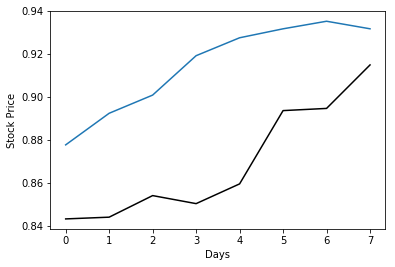

Variação Real 1.08%
Variação Prevista ['1.06%']
Erro ['-0.02%']


In [12]:
plt.plot(np.array(prev)[0:limit].reshape(-1,1))
plt.plot(np.array(testY)[0:limit].reshape(-1,),c='black')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()
real=np.array(testY)[0:limit].reshape(-1,)[-1]/np.array(testY)[0:limit].reshape(-1,)[0]
prevista=np.array(prev)[0:limit].reshape(-1,1)[-1]/np.array(prev)[0:limit].reshape(-1,1)[0]
print('Variação Real',"%.2f" % real + '%')
print('Variação Prevista',["%.2f" % prevista+'%'])
print('Erro',["%.2f" % float(prevista-real)+'%'])